In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)


In [2]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

#dataset_names = !cat NCI60/names
#dataset = dataset_names[4]
#dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
#print 'Working with dataset: %s' % dataset 

dataset_fname = 'bursi.pos.gspan'

In [4]:
%%time
# induce a grammar and train an estimator
training_graphs = get_graphs(dataset_fname, size=300)

from graphlearn.graphlearn import GraphLearnSampler
from eden.graph import Vectorizer
sampler=GraphLearnSampler(radius_list=[0,1], thickness_list=[2],random_state=42447,
                          min_cip_count=2, min_interface_count=2,
                          vectorizer=Vectorizer(3))
#take nu% of data as outlier
sampler.fit(training_graphs, nu=0.25, n_jobs=1)

print('graph grammar stats:')
n_instances, interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances, interface_counts, core_counts, cip_counts))

sampler.save('tmp/sampler.ge')

fitting was asked with n=1

Classifier:
SGDClassifier(alpha=0.000291216671342, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0975129199369, fit_intercept=True,
       l1_ratio=0.15, learning_rate='invscaling', loss='log', n_iter=29,
       n_jobs=1, penalty='l1', power_t=0.288916422987, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
#instances: 300  #interfaces: 122   #cores: 54   #core-interface-pairs: 378
graph grammar stats:
#instances: 300   #interfaces: 122   #cores: 54   #core-interface-pairs: 378
Saved model: tmp/sampler.ge
CPU times: user 34.1 s, sys: 3.22 s, total: 37.4 s
Wall time: 34.7 s


In [5]:
%%time
from graphlearn.graphlearn import GraphLearnSampler
sampler=GraphLearnSampler()
sampler.load('tmp/sampler.ge')

# graph sampling
graphs = get_graphs(dataset_fname, size=100)

id_start=34
id_end=id_start+12
from itertools import islice
graphs = islice(graphs,id_start,id_end)

# sample
n_steps=50
n_samples=5

from graphlearn.graphlearn import GraphLearnSampler
graphs = sampler.sample(graphs,
                        n_steps=n_steps, n_samples=n_samples,
                        target_orig_cip=False,
                        probabilistic_core_choice=False,
                        score_core_choice= True,
                        max_core_size_diff=-1,
                        burnin=1,
                        omit_seed=False,
                   
                        improving_threshold=.8, 
                        improving_linear_start=0.2,
                        accept_static_penalty=0.0,
                        n_jobs=1,
                        select_cip_max_tries=200,
                        keep_duplicates=True  )

Loaded model: tmp/sampler.ge
CPU times: user 280 ms, sys: 44 ms, total: 324 ms
Wall time: 321 ms


preprocessing grammar
_sample_notes: None
accept_static_penalty: 0.0
batch_size: 10
    burnin: 1
estimatorobject: <graphlearn.estimator.Wrapper instance at 0x7fa39abfc290>
feasibility_checker: <graphlearn.feasibility.FeasibilityChecker instance at 0x7fa39abfcc20>
generator_mode: False
hash_bitmask: 1048575
improving_linear_start: 10
improving_penalty_per_step: 0.0333333333333
improving_threshold: 40
keep_duplicates: True
      lsgg: <graphlearn.localsubstitutablegraphgrammar.LocalSubstitutableGraphGrammar object at 0x7fa39b40dcd0>
max_core_size_diff: -2
    n_jobs: 1
   n_steps: 50
      nbit: 20
node_entity_check: <function <lambda> at 0x7fa3a01a0c80>
 omit_seed: False
postprocessor: <graphlearn.processing.PostProcessor object at 0x7fa39d9e5bd0>
preprocessor: <graphlearn.processing.PreProcessor object at 0x7fa3b52a4b90>
probabilistic_core_choice: False
proposal_probability: False
quick_skip_orig_cip: False
radius_list: [0, 2]
random_state: 42447
sample_path: None
sampling_interval: 1

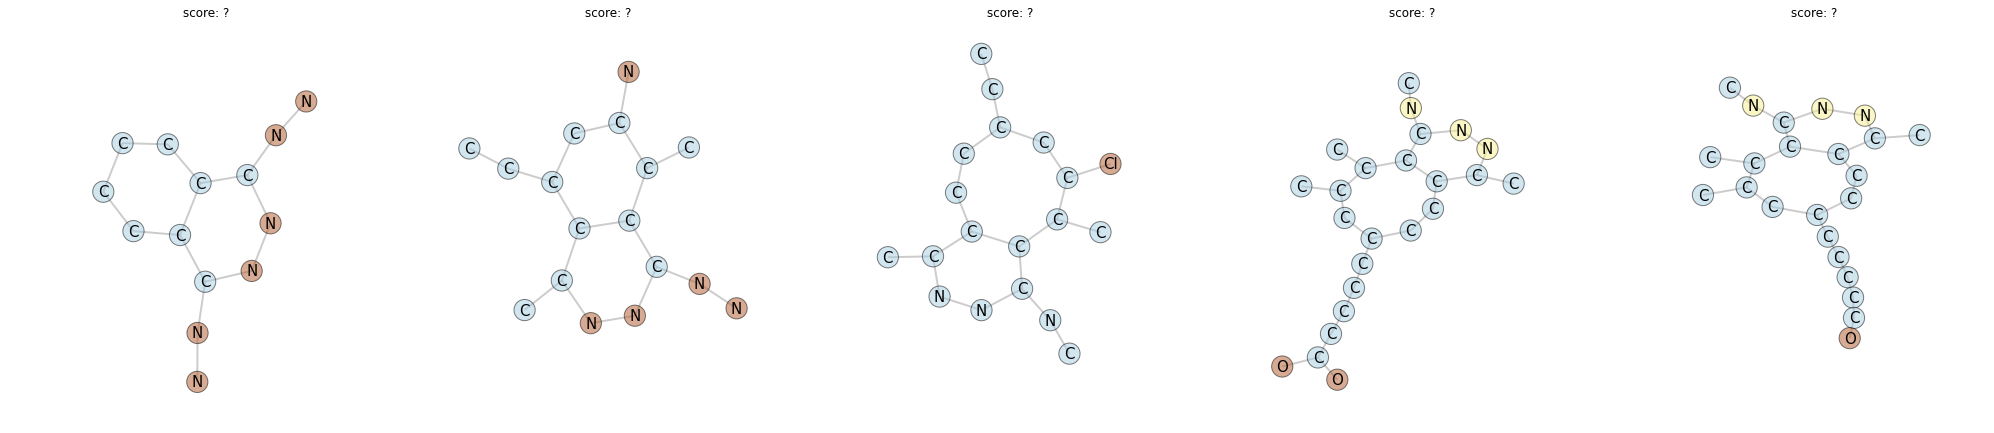

Graph id: 35


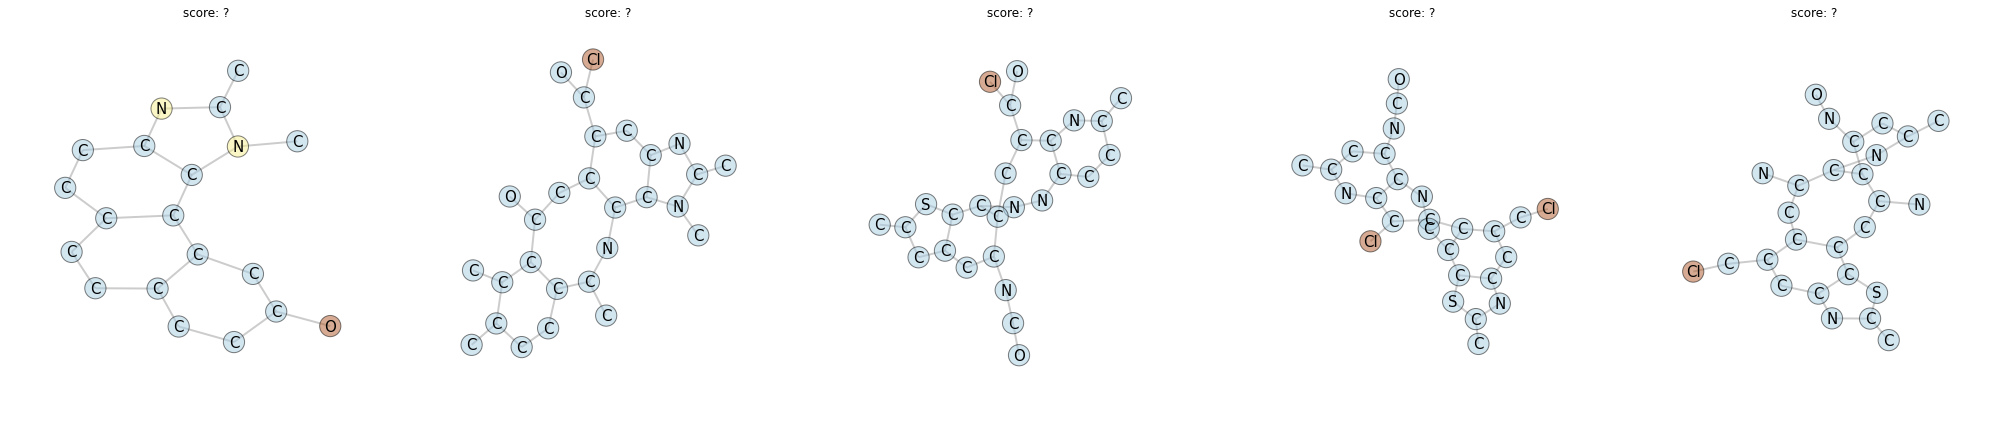

Graph id: 36


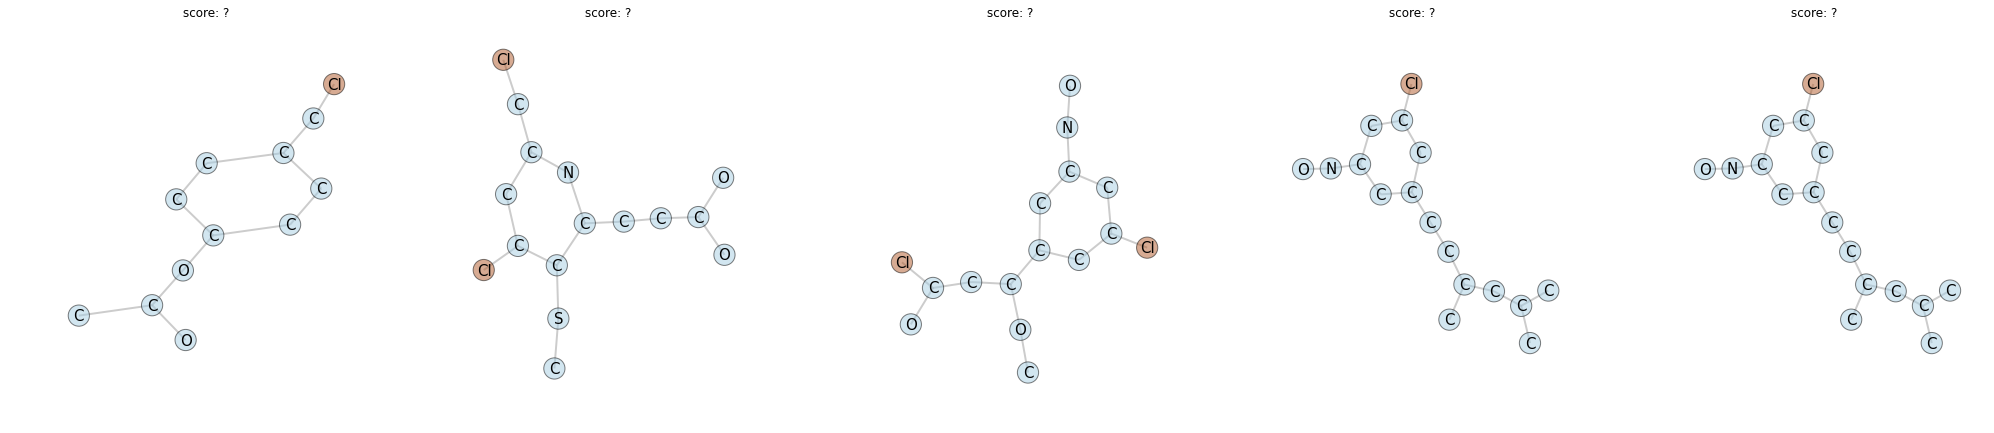

Graph id: 37


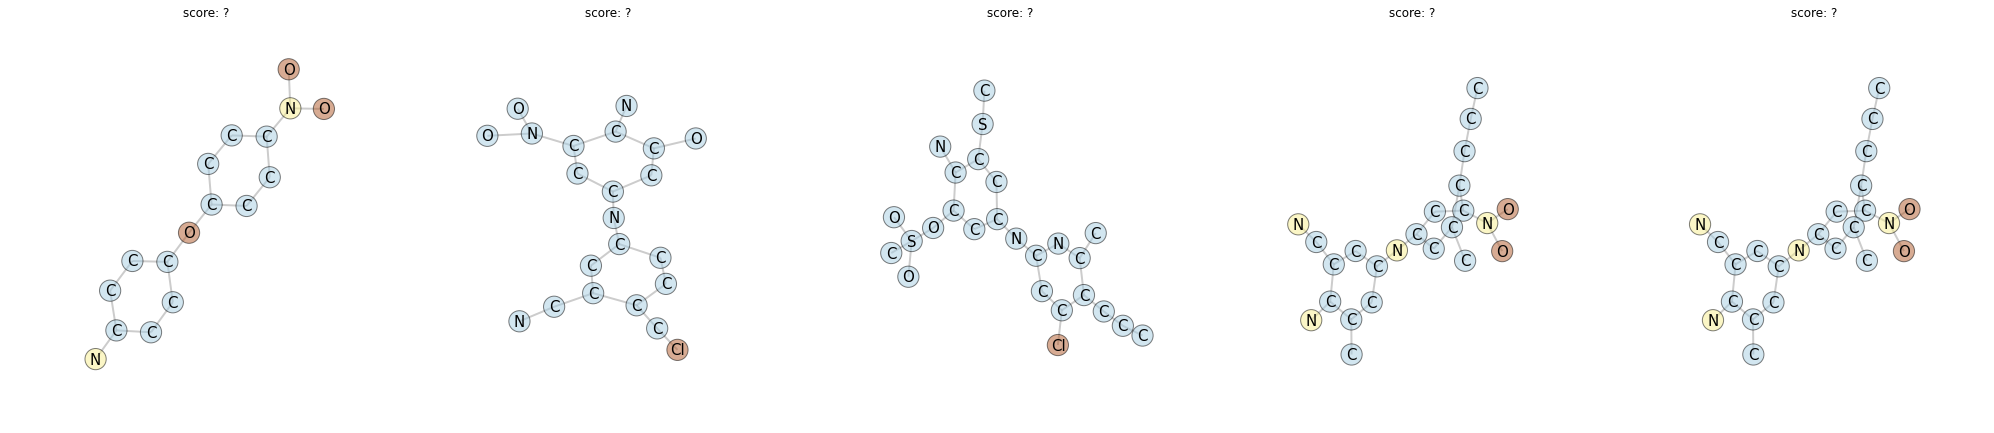

Graph id: 38


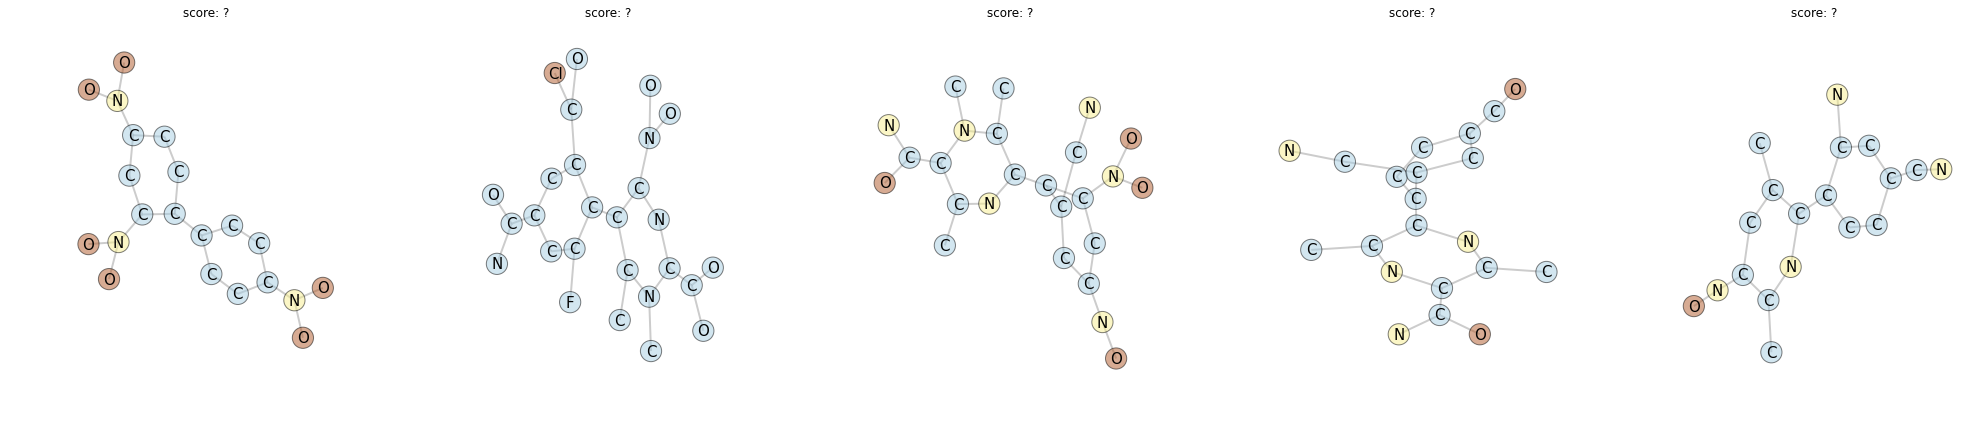

Graph id: 39


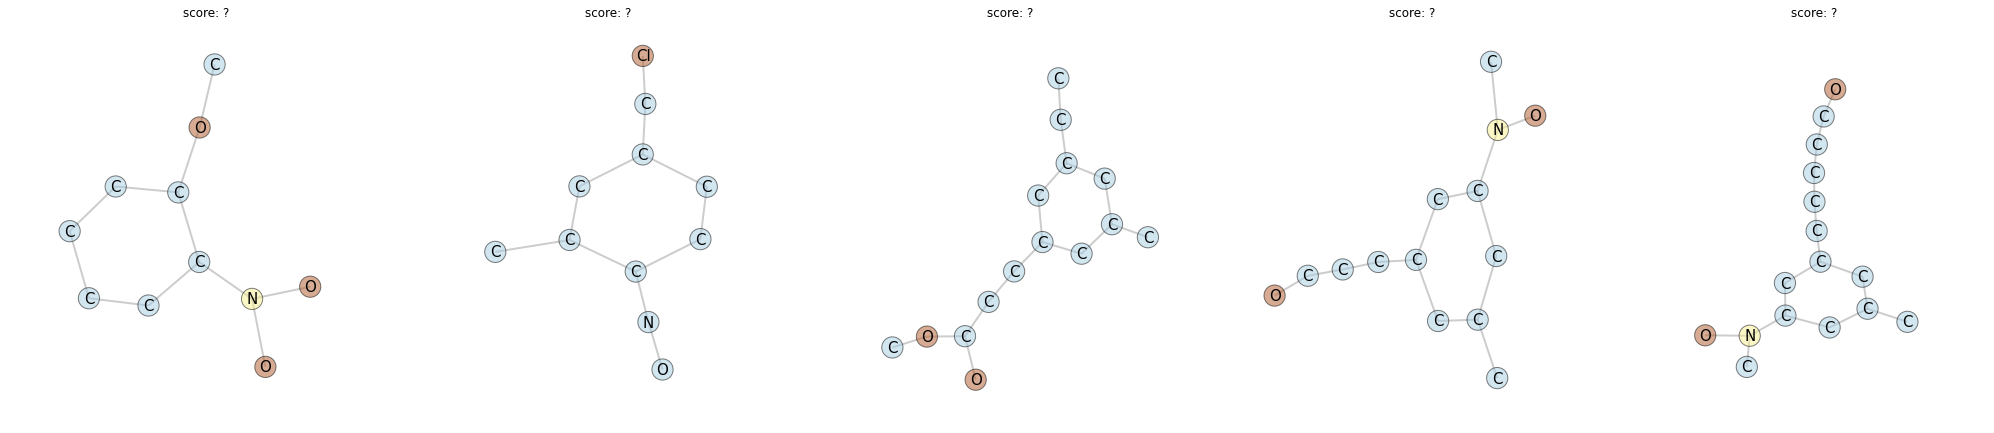

Graph id: 40


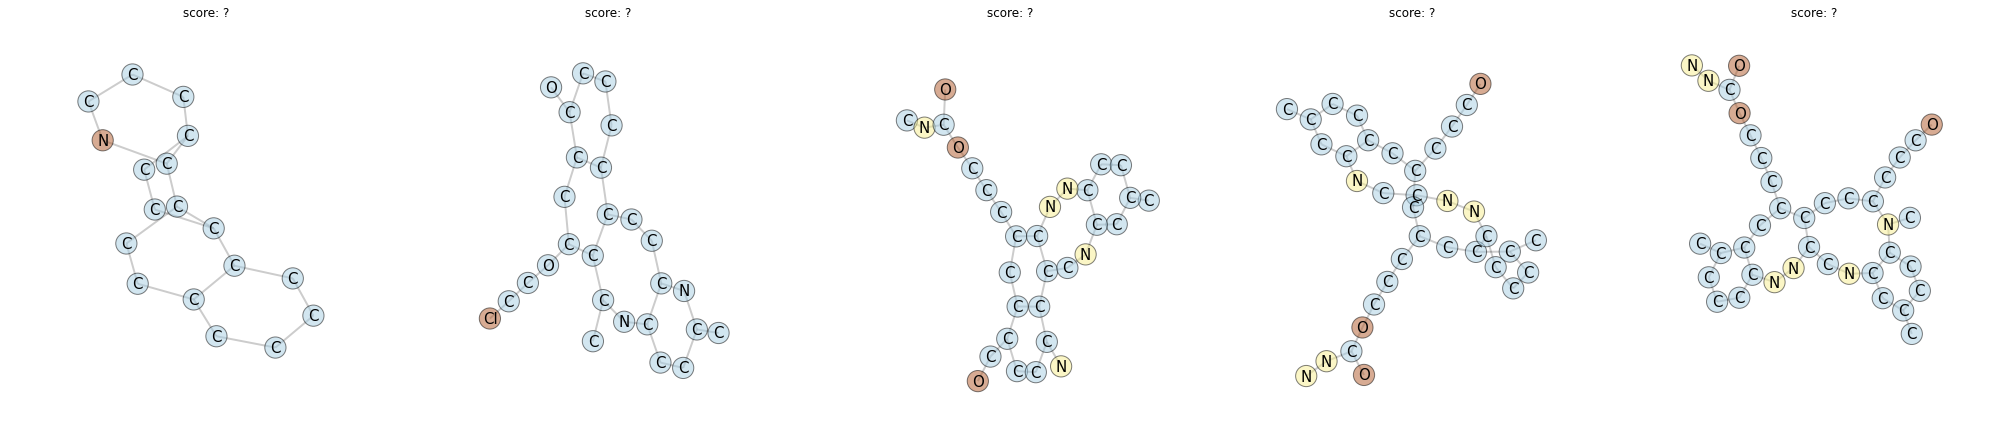

Graph id: 41


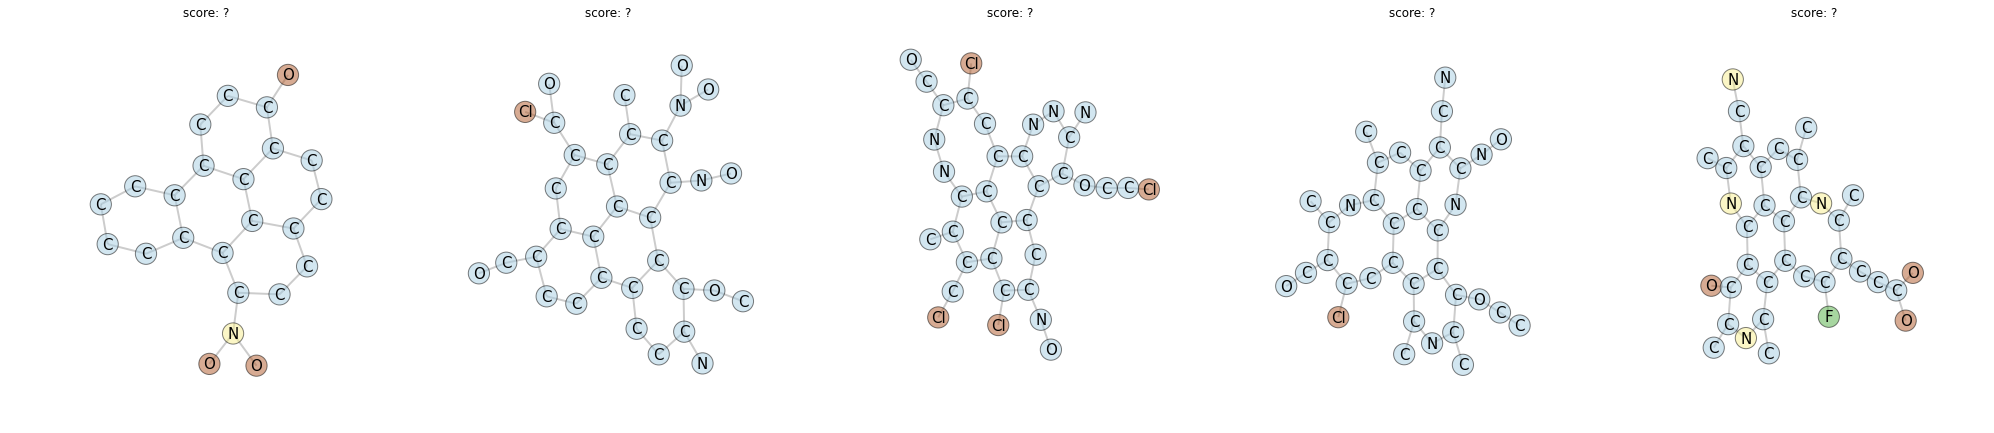

Graph id: 42


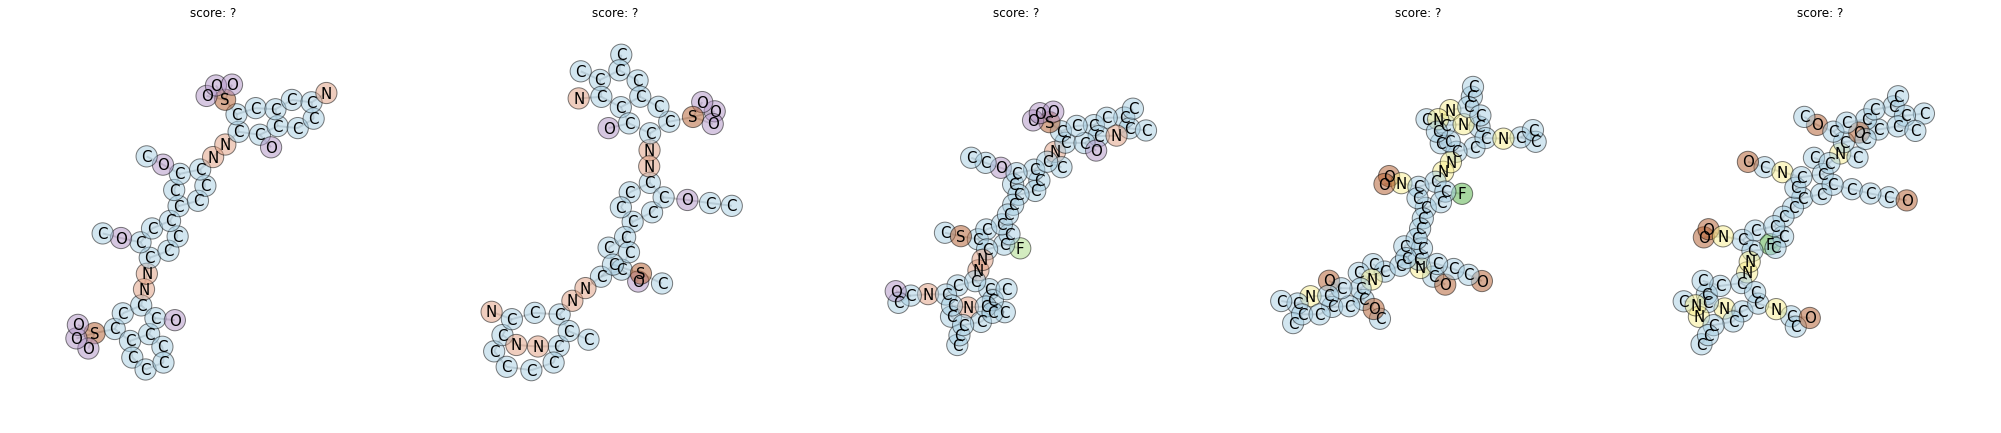

Graph id: 43


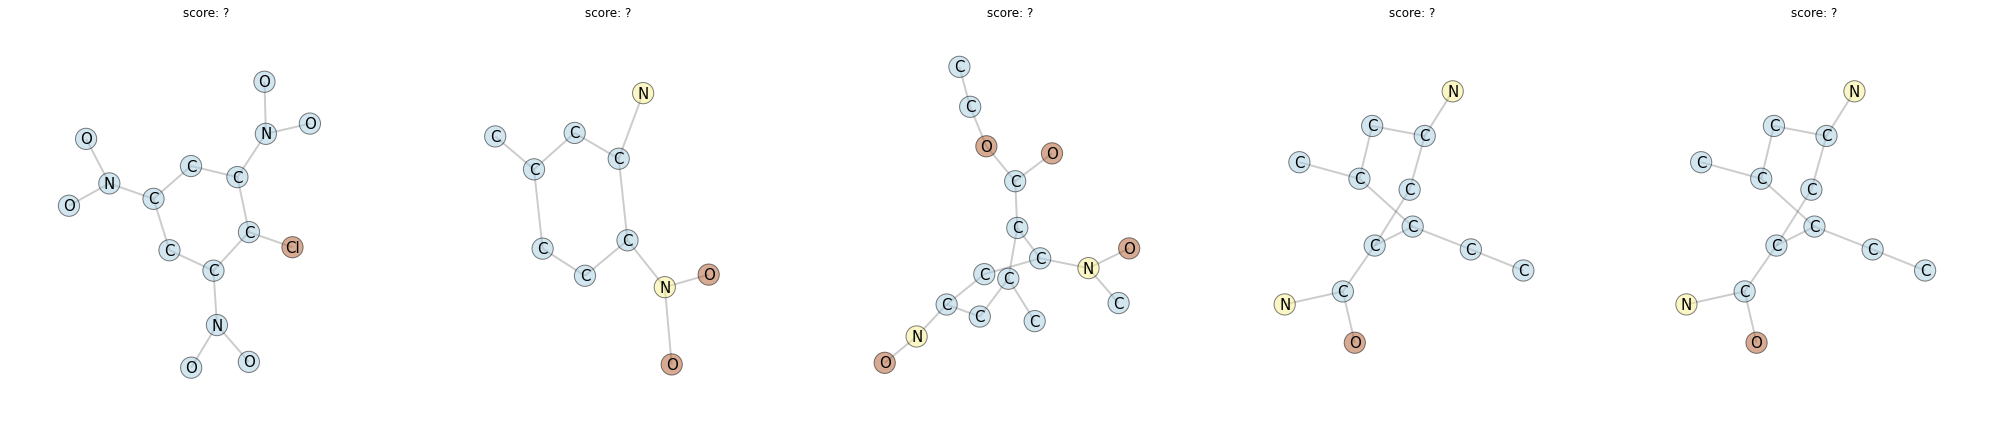

Graph id: 44


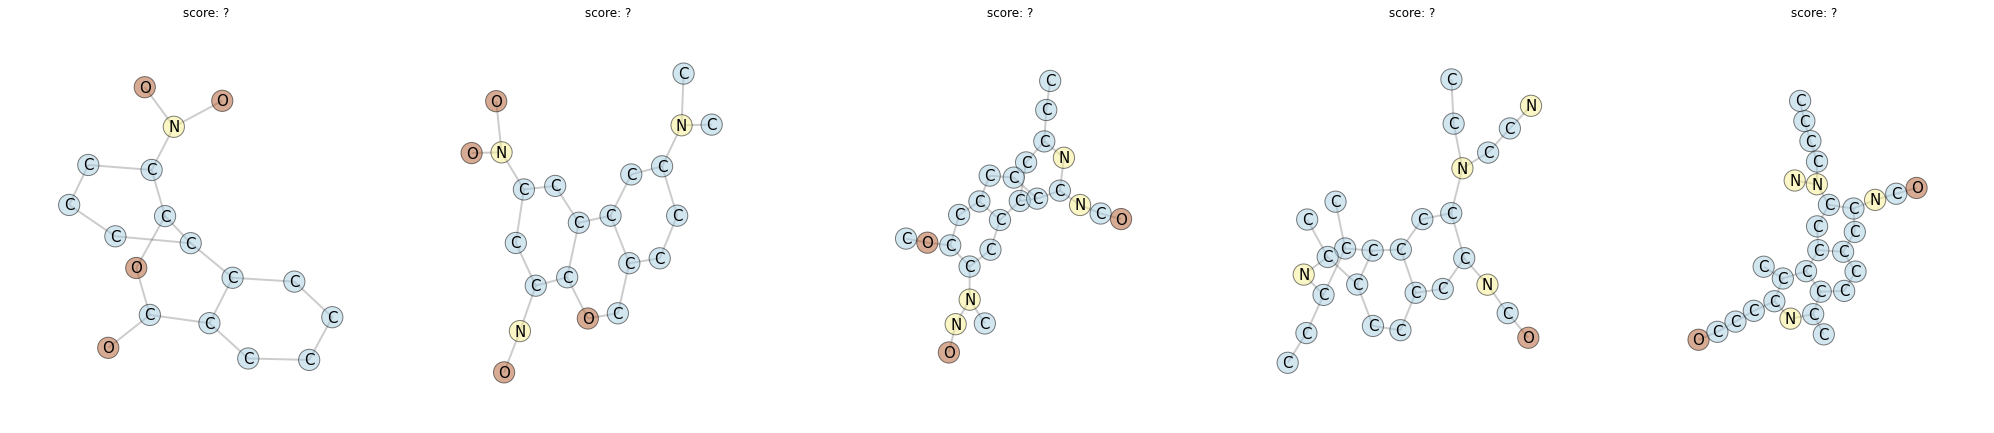

Graph id: 45


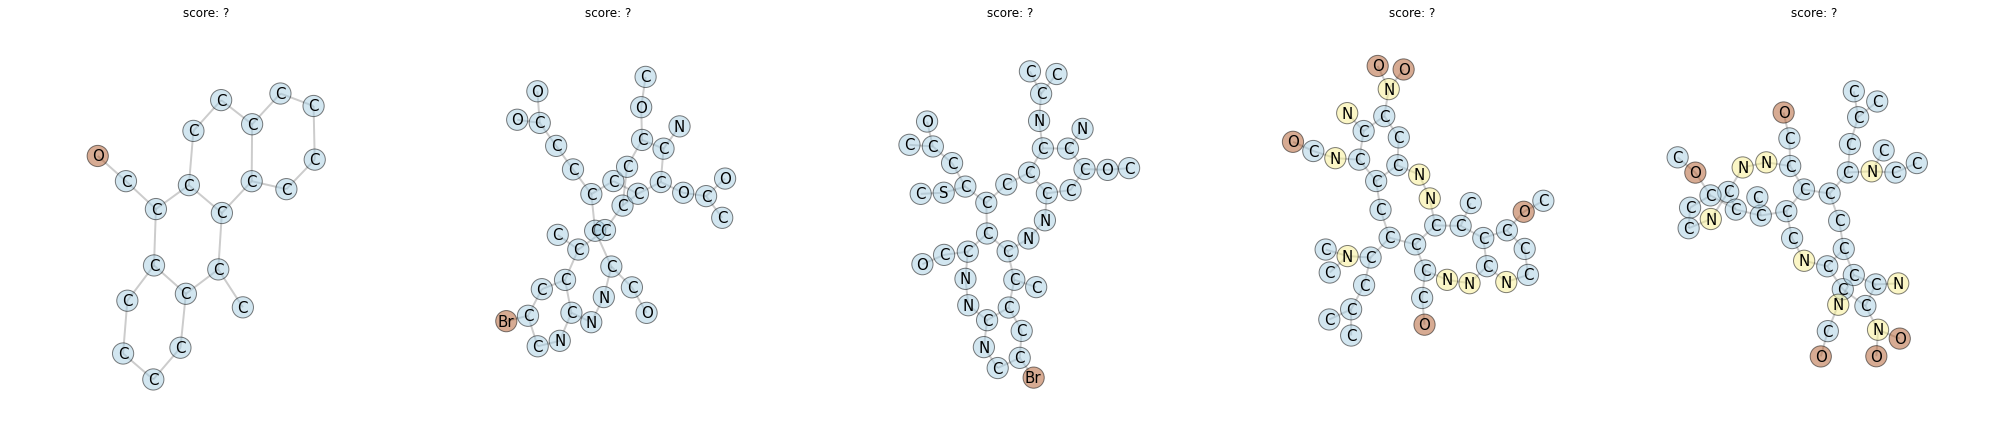

CPU times: user 40 s, sys: 1.25 s, total: 41.2 s
Wall time: 43.9 s


In [6]:
%%time
# plot examples of sampling paths
from graphlearn.utils import draw
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    draw.graphlearn(path_graphs,
                   n_graphs_per_line=6, size=7, 
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='_labels_',
                   vertex_alpha=0.5, edge_alpha=0.2, node_size=450,
                   headlinehook=draw.get_score_of_graph)

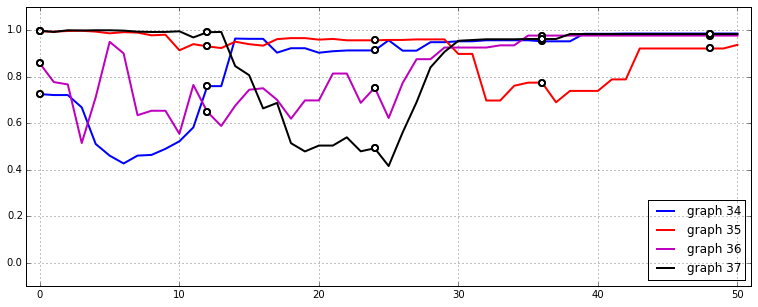

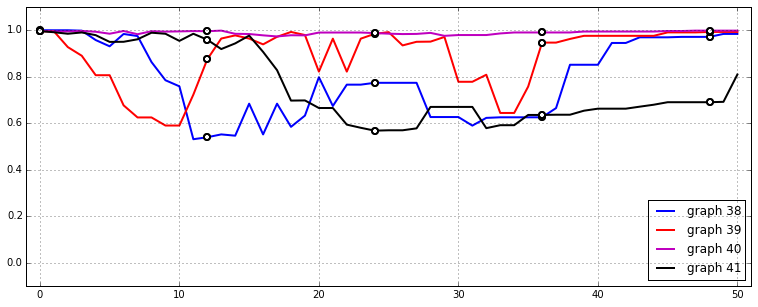

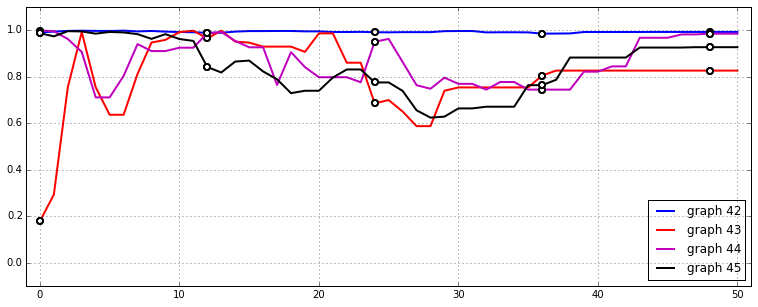

CPU times: user 836 ms, sys: 20 ms, total: 856 ms
Wall time: 848 ms


In [7]:
%%time
# plot sampling path score
from itertools import islice
import numpy as np
import pylab as plt
markevery=n_steps/(n_samples-1)
step=1
num_graphs_per_plot=4
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None',markevery=markevery, markerfacecolor='white', marker='o', markeredgewidth=2,markersize=6)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,n_steps+1)
    plt.ylim(-0.1,1.1)
    plt.show()

.